In [160]:
import fnmatch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# import util

In [2]:
rfDirString = './current/V3_7_precRidge_nofoot_noTCsplit_xco2raw_SA_biasall_all_RF0/model.p'
tcconRidgeDirString = './current/V3_7_nofoot_noTCsplit_xco2_TCCON_biasall_all_Ridge0/model.p'

In [11]:
def read_from_parquet(path):
    with open(path, 'rb') as file:
        try:
            while True:
                yield pd.read_parquet(file)
        except EOFError:
            pass

In [13]:
for item in read_from_parquet(tcconRidgeDirString):
    print(repr(item))

{'X_mean': co2_grad_del            -4.523943
dpfrac                  -0.908135
aod_strataer             0.008313
water_height             0.983796
sensor_zenith_angle     31.158767
t700                   274.413936
dtype: float64, 'y_mean': 0.16948793501280396, 'X_std': co2_grad_del           30.534326
dpfrac                  1.663096
aod_strataer            0.005685
water_height            0.262931
sensor_zenith_angle    19.448298
t700                    7.905067
dtype: float64, 'y_std': 2.0333353433811108, 'TrainedModel': Ridge(alpha=0.0001), 'features': ['co2_grad_del', 'dpfrac', 'aod_strataer', 'water_height', 'sensor_zenith_angle', 't700'], 'model': 'Ridge', 'qf': None, 'mode': 'all', 'footprint': 0}


In [14]:
for item in read_from_parquet(rfDirString):
    print(repr(item))

{'X_mean': co2_grad_del                   -11.008586
dpfrac                          -0.242026
albedo_o2a                       0.171651
rms_rel_o2a                      0.208532
albedo_slope_wco2               -0.000042
aod_strataer                     0.008031
water_height                     0.898721
dp_abp                          -0.352440
color_slice_noise_ratio_o2a      2.113997
altitude                       239.132381
h_continuum_sco2                10.710280
rms_rel_sco2                     0.220404
footprint                        4.509912
dws                              0.080399
dtype: float64, 'y_mean': -0.09454067436644806, 'X_std': co2_grad_del                     24.009773
dpfrac                            1.455216
albedo_o2a                        0.136502
rms_rel_o2a                       0.121967
albedo_slope_wco2                 0.000056
aod_strataer                      0.006400
water_height                      0.261621
dp_abp                            4.275438


In [148]:
# load and plot model results
model_dir = '/Users/williamkeely/Desktop/B11/current/V3_7_nofoot_noTCsplit_MLQF0' # change for Steffen's computer.


error_threshold = [0.5,0.7,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.3,2.5,2.7,2.9,3,3.1]
SA_bias_MLQF0 = []
pct_NOTpassing = []


for i in error_threshold:
    parquet_string = "/V1_14_LndND_nofoot_noTCsplit_MLQFRF0_" + str(i) + "/V1_14_LndND_nofoot_noTCsplit_MLQFRF0_" +str(i) + "_results.parquet"
    results = pd.read_parquet(model_dir + parquet_string)
    SA_bias_MLQF0.append(results['RMSE_SA_MLQF0'])
    pct_NOTpassing.append(100 - results['QF=1_pc'])

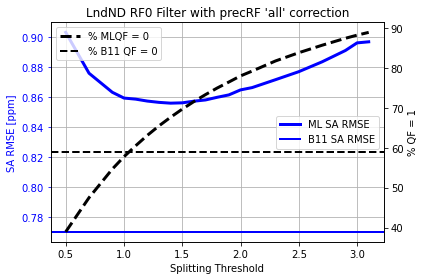

In [156]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(error_threshold,SA_bias_MLQF0, color = 'blue', linewidth = 3)
ax2.plot(error_threshold,pct_NOTpassing, color = 'black', linestyle = 'dashed', linewidth = 3)
ax1.axhline(0.77,color = 'blue', linewidth = 2)
ax2.axhline(59, color = 'black', linewidth = 2, linestyle = 'dashed')

ax1.set_xlabel('Splitting Threshold', color = 'k')
ax1.set_ylabel('SA RMSE [ppm]', color='blue')
ax2.set_ylabel('% QF = 1', color='black')
ax1.tick_params(axis='y', colors='blue')

ax1.legend(['ML SA RMSE','B11 SA RMSE'], loc = 'best')
ax2.legend(['% MLQF = 0','% B11 QF = 0'], loc = 'best')
ax1.grid(True)

plt.title("LndND RF0 Filter with precRF 'all' correction")
plt.tight_layout()
plt.savefig('threshold_rmse_pass.png', dpi = 200)
plt.show()

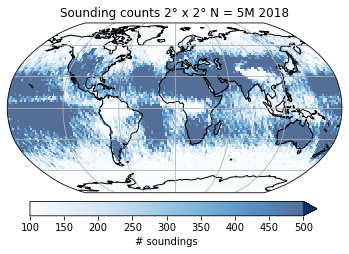

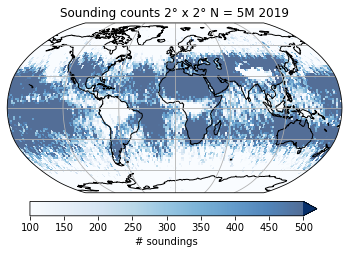

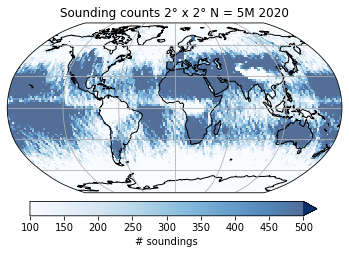

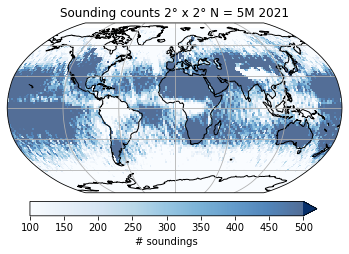

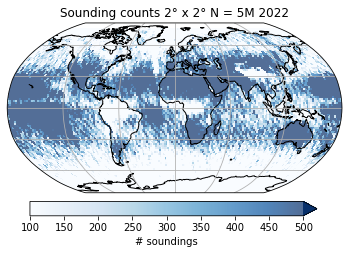

In [169]:
# sounding distribution plots for Steffen
path = "/Users/williamkeely/Desktop/B11/Data/"
years = [2018,2019,2020,2021,2022]
col_names = ['latitude','longitude']
for year in years:
    parquet_string = 'PreLoadB11_snow_5M_all_qfNone_' + str(year)+'.parquet'
    data = pd.read_parquet(os.path.join(path,parquet_string))
    data = data[col_names]
        
        
    result, xedges, yedges = np.histogram2d(data['longitude'],data['latitude'],bins=[180, 90])
    result = result.clip(1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1,
                         projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    im = ax.imshow(result.T, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 100, vmax = 500, transform=ccrs.PlateCarree(), alpha = 0.7)

    ax.set_title("Sounding counts "+ "2"+"\u00b0"+" x 2"+ "\u00b0" + " N = 5M "+ str(year))
    plt.colorbar(im, fraction=0.066, pad=0.04, extend='max', location = 'bottom', label='# soundings')
    plt.savefig(path + "sounding_counts_2deg_"+ str(year)+ ".png", dpi = 300)